# Solving PK ODE systems in TensorFlow
Solving initial value problems in TensorFlow. Originally written for TF 1.9 and scipy as ode solver, adapted for tfdiffeq which seems to perform better. Tested on TF 2.5 and provided as is.

"Analytical solutions" - closed form stuff back from TF1.0

Additional stochastic simulations: mlxR files in sandbox, uses Monolix 2019R1 (check seeds, slighty different
results for y in 2019R2, 2020R1)

## Setup

In [1]:
import numpy as np
import pandas as pd
from tfdiffeq import odeint
import seaborn as sns
import math
import matplotlib.pyplot as plt
import tensorflow as tf

### Helpers
Used for plotting intermediate steps.

In [2]:
def plot_gof( t, y, yhat ):
    yhat = tf.transpose(yhat)[0] # replace
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.scatter( t, y, label="obs")
    ax1.plot( t, yhat, label="ODE")
    ax1.legend()
    ax1.set_title("Concentration curves")
    ax1.set_xlabel("Time [h]")
    ax1.set_ylabel("Conc. [mg/L]")

    ax2.scatter( y, yhat)
    lim = np.amax(np.concatenate((y,yhat)))
    ax2.plot( [0,lim], [0,lim])
    ax2.set_title("obs vs pred")
    ax2.set_xlabel("obs")
    ax2.set_ylabel("pred")
    diag_line, = ax2.plot(lim, lim, ls="--", c=".3")

    fig.tight_layout(pad=3.0)

    return fig


### Analytical solution
closed form stuff for 1CMT_OA

In [3]:
def bateman( dose, ka, V, CL, t):
    kel = CL/V

    return ((dose*ka)/(V*(ka-kel)))*(math.exp(-kel*t)-math.exp(-ka*t))

t_start=0.
t_end=24
t_nsamples=24
t_space = np.linspace(t_start, t_end, t_nsamples)

AMT = 100.0
ka = 0.3
V = 20.0
CL = 5.0

v_bateman = np.vectorize(bateman)
analytical_solution = v_bateman( AMT, ka, V, CL, t_space)

Text(0.5, 0, 'Time [h]')

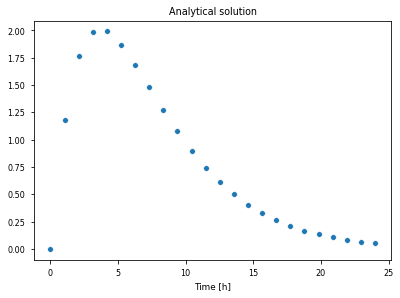

In [4]:
sns.scatterplot(x=t_space, y=analytical_solution)
plt.title( "Analytical solution")
plt.xlabel("Time [h]")

### ODE systems
Implementations of several common structural models

#### 1CMT, intravenous
Bolus

In [5]:
def ODE_1CMT_IV(t, u, args):
    Vd, CL = args[0], args[1]
    kel = CL/Vd
    u_vc = u[0]
    
    dvc_dt = - kel * u_vc
    
    return tf.stack([dvc_dt])

# initial conditions
t_space_tensor = tf.constant(t_space)
vc_init = tf.constant([AMT], dtype=t_space_tensor.dtype)
u_init = tf.convert_to_tensor([vc_init], dtype=t_space_tensor.dtype)

#### 1CMT, extravascular
1st order abs.

In [6]:
def ODE_1CMT_OA(t, u, args):
    ka, Vd, CL = args[0], args[1], args[2]
    kel = CL/Vd
    u_abs, u_vc = u[0], u[1]
    
    dabs_dt = -ka * u_abs
    dvc_dt = ka * u_abs - kel * u_vc
    
    return tf.stack([dabs_dt, dvc_dt])

# initial conditions
t_space_tensor = tf.constant(t_space)
abs_init = tf.constant([AMT], dtype=t_space_tensor.dtype)
vc_init = tf.constant([0.], dtype=t_space_tensor.dtype)
u_init = tf.convert_to_tensor([abs_init, vc_init], dtype=t_space_tensor.dtype)

Quick check of ODE implementation. Labeled as 'numerical solution' though it's actually analytical. For re-use of
code further downstream.

In [7]:
# for demo purposes: array of correct params
args = [ tf.constant([ka], dtype=tf.float64),
         tf.constant([V], dtype=tf.float64),
         tf.constant([CL], dtype=tf.float64)]

def model():
  return odeint(lambda ts, u0: ODE_1CMT_OA(ts, u0, args),
                  u_init, t_space_tensor)

curr_res = model()
abs_curr_res = curr_res[:, 0].numpy()
vc_curr_res = curr_res[:, 1].numpy()/V # has to be scaled to Vd

Visual confirmation

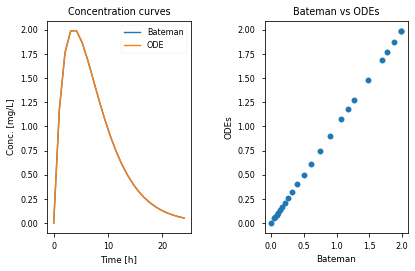

In [8]:
## TODO: port to seaborn
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot( t_space, analytical_solution, label="Bateman")
ax1.plot( t_space, vc_curr_res, label="ODE")
ax1.legend()
ax1.set_title("Concentration curves")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Conc. [mg/L]")

ax2.scatter( analytical_solution, vc_curr_res)
ax2.set_title("Bateman vs ODEs")
ax2.set_xlabel("Bateman")
ax2.set_ylabel("ODEs")

fig.tight_layout(pad=3.0)

## Fitting ODE system
### POC: 1CMT_OA
Proof of concept of rich simulated data. Making sure the ode_ivp is doing its thing. First on deterministic (Cc) and
then on stochastic (y) sims.

#### simulated data
* Cc = typical (Vd 10, CL 5, ka 0.1)
* y = Cc + combined error (prope: 0.1, adde: 0.08)

In [9]:
obs_data = pd.read_csv("DerivedData/1CMT_OA.csv")
obs_data.head()

,time,Cc,y
0,0,0.00,0.000000
1,1,0.75,0.707132
2,2,1.13,1.171021
3,3,1.29,1.292678
4,4,1.34,1.394739


It's not *that* noisy.

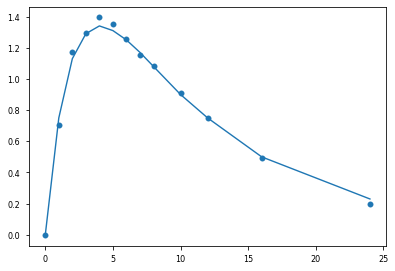

In [10]:
plt.plot( obs_data.time, obs_data.Cc)
plt.scatter( obs_data.time, obs_data.y)
plt.show()

#### Cc (deterministic)
##### initial estimates

In [11]:
args = [tf.Variable(initial_value=1., name='p' + str(i+1), trainable=True,
          dtype=t_space_tensor.dtype) for i in range(0, 3)]

args = [tf.Variable(initial_value=1., name='p' + str(i+1), trainable=True,
          dtype=t_space_tensor.dtype) for i in range(0, 3)]

args = [ tf.Variable(initial_value=0.2, name="p1", trainable=True, dtype=tf.float64), # ka
         tf.Variable(initial_value=12.0, name="p2", trainable=True, dtype=tf.float64), # Vd
         tf.Variable(initial_value=3.5, name="p3", trainable=True, dtype=tf.float64)] # CL

args

[<tf.Variable 'p1:0' shape=() dtype=float64, numpy=0.2>,
 <tf.Variable 'p2:0' shape=() dtype=float64, numpy=12.0>,
 <tf.Variable 'p3:0' shape=() dtype=float64, numpy=3.5>]

The loss function only needs to consider dvc_dt (scaled by Vd). dabs_dt is determined by ka
which also enters in dvc_dt.

##### Using MSE

Epoch # 0  loss: 3.336228609085083 Parms: [0.2, 12.0, 4.0]
Epoch # 10  loss: 0.38356927037239075 Parms: [0.03, 11.61, 4.38]
Epoch # 20  loss: 0.2595917582511902 Parms: [0.03, 11.37, 4.6]
Epoch # 30  loss: 0.26745641231536865 Parms: [0.03, 11.18, 4.75]
Epoch # 40  loss: 0.22347711026668549 Parms: [0.03, 11.0, 4.87]
Epoch # 50  loss: 0.20498786866664886 Parms: [0.04, 10.82, 4.97]
Epoch # 60  loss: 0.18487827479839325 Parms: [0.04, 10.61, 5.09]
Epoch # 70  loss: 0.1659942865371704 Parms: [0.04, 10.38, 5.21]
Epoch # 80  loss: 0.14486436545848846 Parms: [0.05, 10.13, 5.33]
Epoch # 90  loss: 0.12197314947843552 Parms: [0.05, 9.86, 5.47]
Epoch # 100  loss: 0.09206357598304749 Parms: [0.06, 9.55, 5.62]
Epoch # 110  loss: 0.06899063289165497 Parms: [0.06, 9.22, 5.78]
Epoch # 120  loss: 0.04883522540330887 Parms: [0.07, 8.94, 5.92]
Epoch # 130  loss: 0.054258737713098526 Parms: [0.07, 8.75, 6.02]
Epoch # 140  loss: 0.047292694449424744 Parms: [0.08, 8.64, 6.09]
Final parms: [0.07646043467823484,

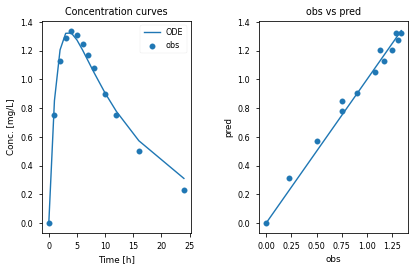

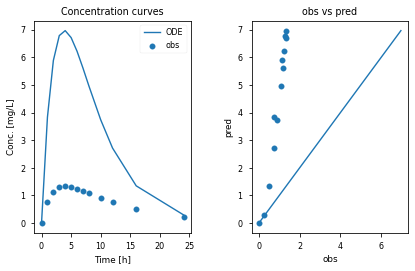

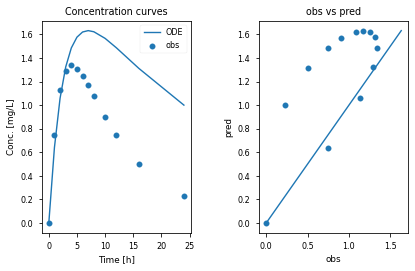

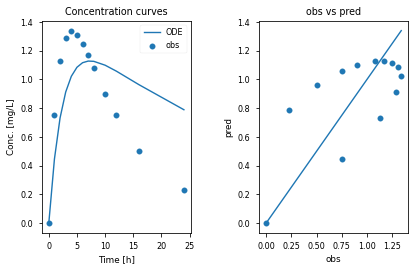

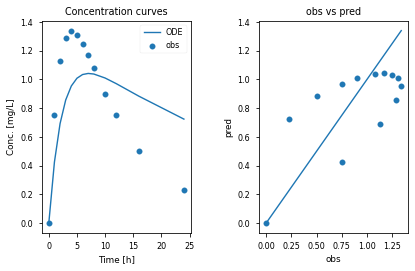

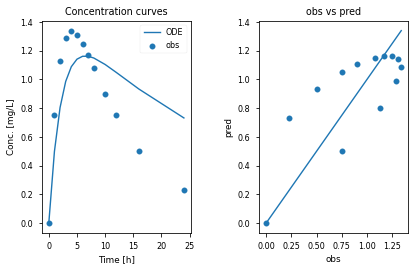

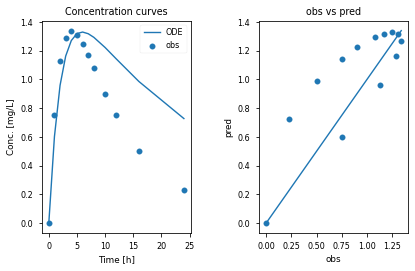

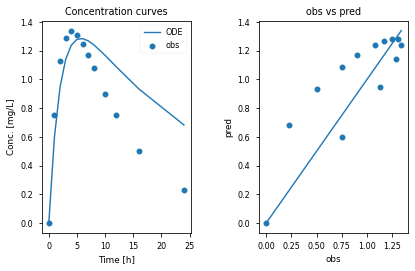

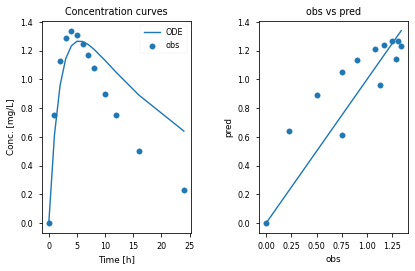

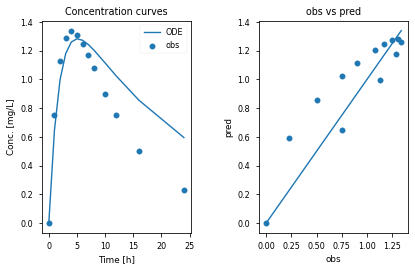

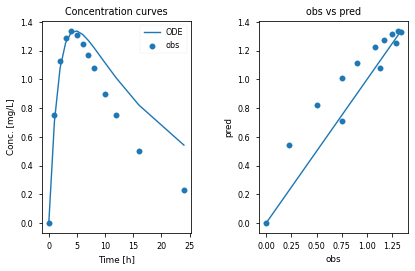

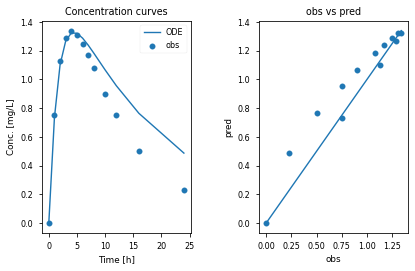

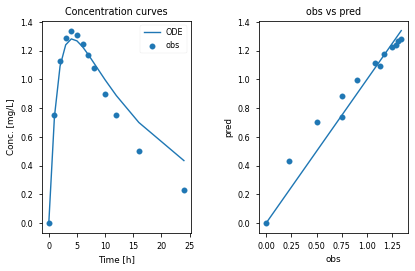

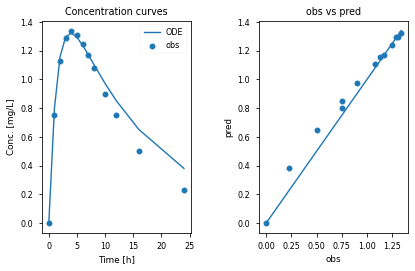

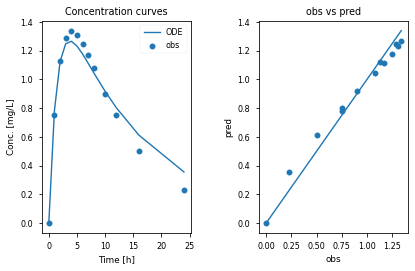

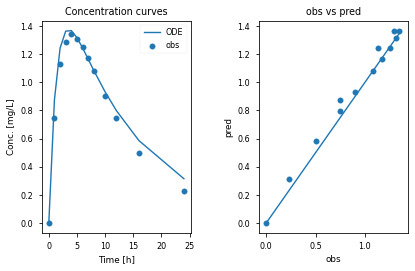

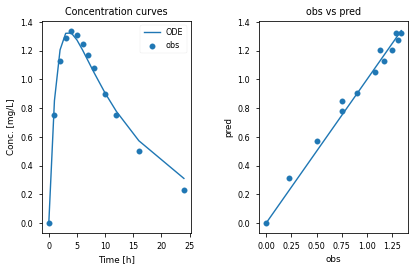

In [12]:
t_space_tensor = tf.constant(obs_data.time, dtype=tf.float64)
abs_init = tf.constant([AMT], dtype=t_space_tensor.dtype) #t_space_tensor.dtype)
vc_init = tf.constant([0.], dtype=t_space_tensor.dtype)
u_init = tf.convert_to_tensor([abs_init, vc_init], dtype=t_space_tensor.dtype)

args = [ tf.Variable(initial_value=0.2, name="p1", trainable=True, dtype=tf.float64), # ka
         tf.Variable(initial_value=12.0, name="p2", trainable=True, dtype=tf.float64), # Vd
         tf.Variable(initial_value=4, name="p3", trainable=True, dtype=tf.float64)]

y = tf.constant( obs_data.Cc, dtype=tf.float64)

## mse
mse = tf.keras.losses.MeanAbsoluteError( reduction=tf.keras.losses.Reduction.SUM )
def loss_func(curr_res):
    pred = tf.divide( curr_res[:,1], args[2])
    return mse(y, pred)

def model():
  return odeint(lambda ts, u0: ODE_1CMT_OA(ts, u0, args),
                  u_init, t_space_tensor)

learning_rate = 0.05
epochs = 150
verbose = 10 # print every .. lines
opt = tf.optimizers.Adam(learning_rate=learning_rate)

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    curr_res = model()
    loss_value = loss_func(curr_res)
  if epoch % verbose == 0:
      plot_gof(obs_data.time, y, curr_res[:,1]/args[2]).savefig("./Plots/tf_1cmt_oa_fit_{:03d}.png".format(epoch),dpi=200)
      print("Epoch #", epoch, " loss:", loss_value.numpy(), "Parms:", [round(args[i].numpy(),2) for i in range(0, 3)])
  grads = tape.gradient(loss_value, args)
  opt.apply_gradients(zip(grads, args))

print("Final parms:", [args[i].numpy() for i in range(0, 3)])

curr_res = model()
vc_curr_res = curr_res[:,1]/args[2]
plot_gof(obs_data.time, y, vc_curr_res)

Export as animated GIF.

In [13]:
import imageio
images = []
for i in np.arange( 0, epochs, 10 ):
    images.append(imageio.imread("./Plots/tf_1cmt_oa_fit_{:03d}.png".format(i)))
imageio.mimsave('./Plots/tf_1cmt_oa_fit.gif', images,duration = 0.25)

This loss works much better.

Text(0.5, 0.98, 'Loss: MSE')

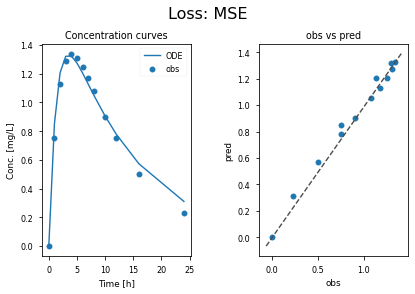

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter( obs_data.time, y, label="obs")
ax1.plot( obs_data.time, vc_curr_res[:,0], label="ODE")
ax1.legend()
ax1.set_title("Concentration curves")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Conc. [mg/L]")

ax2.scatter( y, vc_curr_res[:,0])
ax2.set_title("obs vs pred")
ax2.set_xlabel("obs")
ax2.set_ylabel("pred")
diag_line, = ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")

fig.tight_layout(pad=3.0)
fig.suptitle("Loss: MSE", fontsize=16)

#### y (stochastic)

In [15]:
t_space_tensor = tf.constant(obs_data.time, dtype=tf.float64)
abs_init = tf.constant([AMT], dtype=t_space_tensor.dtype) #t_space_tensor.dtype)
vc_init = tf.constant([0.], dtype=t_space_tensor.dtype)
u_init = tf.convert_to_tensor([abs_init, vc_init], dtype=t_space_tensor.dtype)

args = [ tf.Variable(initial_value=0.2, name="p1", trainable=True, dtype=tf.float64), # ka
         tf.Variable(initial_value=12.0, name="p2", trainable=True, dtype=tf.float64), # Vd
         tf.Variable(initial_value=4, name="p3", trainable=True, dtype=tf.float64)]

y = tf.constant( obs_data.y, dtype=tf.float64)

## mse
mse = tf.keras.losses.MeanAbsoluteError( reduction=tf.keras.losses.Reduction.SUM )
def loss_func(curr_res):
    pred = tf.divide( curr_res[:,1], args[2])
    return mse(y, pred)

def model():
  return odeint(lambda ts, u0: ODE_1CMT_OA(ts, u0, args),
                  u_init, t_space_tensor)

learning_rate = 0.05
epochs = 150
verbose = 10 # print every .. lines
opt = tf.optimizers.Adam(learning_rate=learning_rate)

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    curr_res = model()
    loss_value = loss_func(curr_res)
  # print("Epoch #", epoch, " loss:", loss_value.numpy())
  if epoch % verbose == 0:
      print("Epoch #", epoch, " loss:", loss_value.numpy(), "Parms:", [round(args[i].numpy(),2) for i in range(0, 3)])
  grads = tape.gradient(loss_value, args)
  opt.apply_gradients(zip(grads, args))

print("Final parms:", [args[i].numpy() for i in range(0, 3)])

curr_res = model()
vc_curr_res = curr_res[:,1]/args[2]


Epoch # 0  loss: 3.3319952487945557 Parms: [0.2, 12.0, 4.0]
Epoch # 10  loss: 0.3790517747402191 Parms: [0.03, 11.61, 4.38]
Epoch # 20  loss: 0.26873818039894104 Parms: [0.03, 11.37, 4.6]
Epoch # 30  loss: 0.2678639590740204 Parms: [0.03, 11.18, 4.75]
Epoch # 40  loss: 0.23293714225292206 Parms: [0.03, 11.0, 4.87]
Epoch # 50  loss: 0.21370559930801392 Parms: [0.03, 10.81, 4.98]
Epoch # 60  loss: 0.194645956158638 Parms: [0.04, 10.6, 5.09]
Epoch # 70  loss: 0.175157368183136 Parms: [0.04, 10.37, 5.21]
Epoch # 80  loss: 0.15161246061325073 Parms: [0.05, 10.11, 5.34]
Epoch # 90  loss: 0.12544816732406616 Parms: [0.05, 9.81, 5.49]
Epoch # 100  loss: 0.10282967984676361 Parms: [0.06, 9.52, 5.64]
Epoch # 110  loss: 0.08117026090621948 Parms: [0.06, 9.24, 5.78]
Epoch # 120  loss: 0.0629100352525711 Parms: [0.07, 8.96, 5.91]
Epoch # 130  loss: 0.05367545038461685 Parms: [0.07, 8.72, 6.03]
Epoch # 140  loss: 0.051867056638002396 Parms: [0.08, 8.61, 6.1]
Final parms: [0.07950814606370282, 8.5679

Also converges. This can be sped up by adjusting the optimizer. Here's a visual:

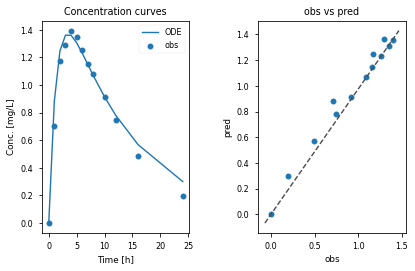

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter( obs_data.time, y, label="obs")
ax1.plot( obs_data.time, vc_curr_res[:,0], label="ODE")
ax1.legend()
ax1.set_title("Concentration curves")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Conc. [mg/L]")

ax2.scatter( y, vc_curr_res[:,0])
ax2.set_title("obs vs pred")
ax2.set_xlabel("obs")
ax2.set_ylabel("pred")
diag_line, = ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")

fig.tight_layout(pad=3.0)